# 

# Employee Attrition 



Uncover the factors that lead to employee attrition and explore important drivers of employee attrition.

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt 
import matplotlib
from sklearn.model_selection import train_test_split
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,precision_recall_curve,plot_precision_recall_curve,f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats
import itertools  
from scipy.stats import mannwhitneyu
from sklearn.tree import  plot_tree 
import numpy as np
# selection of algorithms to consider and set performance measure
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RepeatedStratifiedKFold
import skopt
from skopt import BayesSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
import os
from sklearn.ensemble import IsolationForest
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')
os.getcwd()


'/ceph/users/akhaleghei/notebooks'

# Reading Data

In [3]:
#path = '/Users/Vahid/Library/CloudStorage/OneDrive-UniversityofToronto/MMA - 2022 -/Jupyter files/Data/'
#path = 'C:\\Users\\Vahid\\OneDrive - University of Toronto\\MMA - 2022 -\\Jupyter files\\DATA\\'
data = pd.read_csv('attrition.csv')
data.drop('Unnamed: 0',axis=1, inplace=True)
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life_Sciences,Medium,Female,...,Excellent,Low,0,8,0,Bad,6,4,0,5
1,49,No,Travel_Frequently,279,Research_Development,8,Below_College,Life_Sciences,High,Male,...,Outstanding,Very_High,1,10,3,Better,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research_Development,2,College,Other,Very_High,Male,...,Excellent,Medium,0,7,3,Better,0,0,0,0
3,33,No,Travel_Frequently,1392,Research_Development,3,Master,Life_Sciences,Very_High,Female,...,Excellent,High,0,8,3,Better,8,7,3,0
4,27,No,Travel_Rarely,591,Research_Development,2,Below_College,Medical,Low,Male,...,Excellent,Very_High,1,6,3,Better,2,2,2,2


## Cost justification of employee attrition 

In [4]:
# Avg. salary per job level 
salary_job_levbel = data.groupby(['JobLevel'])['MonthlyIncome'].mean().reset_index().round(2)
salary_job_levbel.set_index('JobLevel',inplace=True)
salary_job_levbel.T

JobLevel,1,2,3,4,5
MonthlyIncome,2786.92,5502.28,9817.25,15503.78,19191.83


In [5]:
# Attrition rate by job level 
attrition_rate_by_levbel = pd.crosstab(data['Attrition'],data['JobLevel'], margins=True).T
attrition_rate_by_levbel['percentage_Yes'] = attrition_rate_by_levbel['Yes']/attrition_rate_by_levbel['All']
attrition_rate_by_levbel

Attrition,No,Yes,All,percentage_Yes
JobLevel,,,,
1,400,143,543,0.263352
2,482,52,534,0.097378
3,186,32,218,0.146789
4,101,5,106,0.047170
5,64,5,69,0.072464
All,1233,237,1470,0.161224


<AxesSubplot:xlabel='Attrition', ylabel='count'>

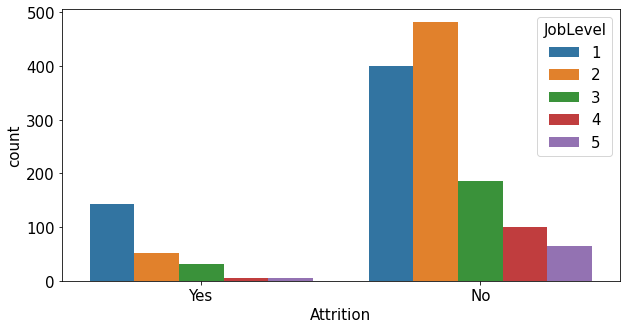

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='Attrition',hue='JobLevel',data=data)

In [7]:
current_cost = salary_job_levbel.merge(attrition_rate_by_levbel,left_index=True, right_index=True,how='left')
current_cost['cost_replacement'] = current_cost['Yes'] * (current_cost['MonthlyIncome']*9)
current_cost

,MonthlyIncome,No,Yes,All,percentage_Yes,cost_replacement
JobLevel,,,,,,
1,2786.92,400,143,543,0.263352,3586766.04
2,5502.28,482,52,534,0.097378,2575067.04
3,9817.25,186,32,218,0.146789,2827368.00
4,15503.78,101,5,106,0.047170,697670.10
5,19191.83,64,5,69,0.072464,863632.35


In [8]:
print('Cost of emplyee replacement: $', current_cost.sum(axis=0)['cost_replacement'].round(2))
print('Total attrition rate among all job levels: $', (current_cost.sum(axis=0)['Yes']/current_cost.sum(axis=0)['No']).round(2))

Cost of emplyee replacement: $ 10550503.53
Total attrition rate among all job levels: $ 0.19


In [9]:
# by only 1 percent change in attrition rate in all job levels:
current_cost['5% deduction in attrition'] = np.floor((current_cost['percentage_Yes'] - current_cost['percentage_Yes'] *.05)*current_cost['All'])
current_cost['5% reduction cost of replacement'] = current_cost['5% deduction in attrition'] * (current_cost['MonthlyIncome']*9).round(2)
current_cost

,MonthlyIncome,No,Yes,All,percentage_Yes,cost_replacement,5% deduction in attrition,5% reduction cost of replacement
JobLevel,,,,,,,,
1,2786.92,400,143,543,0.263352,3586766.04,135.0,3386107.80
2,5502.28,482,52,534,0.097378,2575067.04,49.0,2426505.48
3,9817.25,186,32,218,0.146789,2827368.00,30.0,2650657.50
4,15503.78,101,5,106,0.047170,697670.10,4.0,558136.08
5,19191.83,64,5,69,0.072464,863632.35,4.0,690905.88


In [10]:
print('Cost of emplyee replacement after 5% reduction in attrition rate in all job levels: $', current_cost.sum(axis=0)['5% reduction cost of replacement'])
print('Number of employees stayed longer: {} out of {}'.format(current_cost.sum(axis=0)['Yes']-current_cost.sum(axis=0)['5% deduction in attrition'],current_cost.sum(axis=0)['All'] ))
print('Money has been saved: $ {}'.format(current_cost.sum(axis=0)['cost_replacement'] - current_cost.sum(axis=0)['5% reduction cost of replacement']))

Cost of emplyee replacement after 5% reduction in attrition rate in all job levels: $ 9712312.74
Number of employees stayed longer: 15.0 out of 1470.0
Money has been saved: $ 838190.7899999991


# Function to evaluate performance of different model

In [11]:
def evaluate(model, Y_test, X_test,X_train,Y_train): 
    
    # predict the target on the train dataset
    predict_train = model.predict(X_train)

    # Accuray Score on train dataset
    accuracy_train = accuracy_score(Y_train,predict_train)
    print('Accuracy Score on train dataset : ', round(accuracy_train,2))

    # predict the target on the test dataset
    predict_test = model.predict(X_test)

    # Accuracy Score on test dataset
    accuracy_test = accuracy_score(Y_test,predict_test)
    print('Accuracy_score on test dataset : ', round(accuracy_test,2), '\n')
    
    precision = precision_score(Y_test,  predict_test)
    recall = recall_score(Y_test,  predict_test)
    accuracy= accuracy_score(Y_test,  predict_test)
    F1_score= f1_score(Y_test,  predict_test)

    print('Model Performance')
    print('Precision: {}'.format(round(precision,2)))
    print('Recall: {}'.format(round(recall,2)))
    print('Accuracy:{}'.format(round(accuracy,2)))
    print('F1-score: : {}'.format(round(F1_score,2)),'\n')

# Dummy Encoding

In [12]:
data_transformed = pd.get_dummies(data, columns=data.columns[data.dtypes=='object'], drop_first=True)
data_transformed.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,JobLevel,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,...,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,PerformanceRating_Outstanding,RelationshipSatisfaction_Low,RelationshipSatisfaction_Medium,RelationshipSatisfaction_Very_High,WorkLifeBalance_Best,WorkLifeBalance_Better,WorkLifeBalance_Good
0,41,1102,1,94,2,5993,19479,8,11,0,...,0,1,1,0,1,0,0,0,0,0
1,49,279,8,61,2,5130,24907,1,23,1,...,1,0,0,1,0,0,1,0,1,0
2,37,1373,2,92,1,2090,2396,6,15,0,...,0,1,1,0,0,1,0,0,1,0
3,33,1392,3,56,1,2909,23159,1,11,0,...,1,0,1,0,0,0,0,0,1,0
4,27,591,2,40,1,3468,16632,9,12,1,...,1,0,0,0,0,0,1,0,1,0


# Split dataset to Trains and Test set (dont forget to set the seed)

In [13]:
# define Matrix of features (X) and label(Y) Variables
X = data_transformed.loc[:,~data_transformed.columns.isin(['Attrition_Yes'])].values
Y = data_transformed.loc[:, 'Attrition_Yes'].values

#Split the data into training and testing 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

# Fitting Tree Classifier to the Train set

### Base Tree Classifier

In [14]:
tree_1 = DecisionTreeClassifier(random_state=2)
tree_1.fit(X_train,Y_train)
evaluate(tree_1, Y_test, X_test,X_train,Y_train)

Accuracy Score on train dataset :  1.0
Accuracy_score on test dataset :  0.8 

Model Performance
Precision: 0.32
Recall: 0.37
Accuracy:0.8
F1-score: : 0.34 



### Parameter Tuning Tree Classifier using Cross-Validation

In [15]:
# Create the parameter 
tree_1 = DecisionTreeClassifier(random_state=2)

param_grid = {
    'max_depth': [3, 4, 5,10],
    'min_samples_leaf': [3, 4, 5,10],
    'min_samples_split': [3, 4, 5,10,15],
    'random_state': [2]
}

# Instantiate the grid search model
tree_cv = GridSearchCV(estimator = tree_1, param_grid = param_grid, scoring = 'recall', cv = 10, n_jobs = -1, verbose = 0)
tree_cv.fit(X_train, Y_train)
evaluate(tree_cv, Y_test, X_test,X_train,Y_train)

Accuracy Score on train dataset :  0.95
Accuracy_score on test dataset :  0.81 

Model Performance
Precision: 0.29
Recall: 0.24
Accuracy:0.81
F1-score: : 0.27 



### More details on Cross-Validation and parameters tuning 

In [16]:
df_cv_result_tree = pd.DataFrame(tree_cv.cv_results_)
df_cv_result_tree[['param_max_depth','param_min_samples_leaf','param_min_samples_split','split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'mean_fit_time',
       'rank_test_score']].rename(columns = {'param_max_depth':'max_depth' ,
                                            'param_min_samples_leaf':'min_sample_leaf',
                                            'param_min_samples_split':'min_sample_split',
                                            'mean_fit_time': 'mean_time',
                                            'mean_test_score': 'mean_score',
                                            'rank_test_score': 'rank_score',
                                            'split0_test_score': 'CV0', 'split1_test_score': 'CV1',
                                            'split2_test_score': 'CV2', 'split3_test_score': 'CV3',
                                            'split4_test_score': 'CV4', 'split5_test_score': 'CV5',
                                            'split6_test_score': 'CV6', 'split7_test_score': 'CV7',
                                            'split8_test_score': 'CV8', 'split9_test_score': 'CV9',
                                            }).sort_values(by='rank_score').round(2)

,max_depth,min_sample_leaf,min_sample_split,CV0,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,mean_score,mean_time,rank_score
60,10,3,3,0.30,0.35,0.35,0.20,0.55,0.35,0.37,0.42,0.32,0.47,0.37,0.01,1
61,10,3,4,0.30,0.35,0.35,0.20,0.55,0.35,0.37,0.42,0.32,0.47,0.37,0.01,1
62,10,3,5,0.30,0.35,0.35,0.20,0.55,0.35,0.37,0.42,0.32,0.47,0.37,0.01,1
74,10,5,15,0.50,0.35,0.20,0.15,0.45,0.30,0.26,0.58,0.16,0.53,0.35,0.01,4
73,10,5,10,0.40,0.30,0.20,0.20,0.45,0.35,0.37,0.58,0.16,0.42,0.34,0.01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,3,4,10,0.25,0.10,0.05,0.05,0.20,0.05,0.26,0.21,0.16,0.32,0.16,0.00,76
7,3,4,5,0.25,0.10,0.05,0.05,0.20,0.05,0.26,0.21,0.16,0.32,0.16,0.00,76
6,3,4,4,0.25,0.10,0.05,0.05,0.20,0.05,0.26,0.21,0.16,0.32,0.16,0.00,76
5,3,4,3,0.25,0.10,0.05,0.05,0.20,0.05,0.26,0.21,0.16,0.32,0.16,0.00,76


<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_score'>

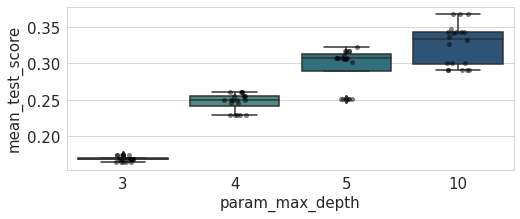

In [17]:
plt.figure(figsize=(8,3))
sns.set_style("whitegrid") 
sns.boxplot(x = 'param_max_depth', y = 'mean_test_score', data = df_cv_result_tree,palette="crest")
sns.stripplot(y='mean_test_score', x='param_max_depth', 
                   data=df_cv_result_tree, jitter=True,marker='o', alpha=0.5,color='black')

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

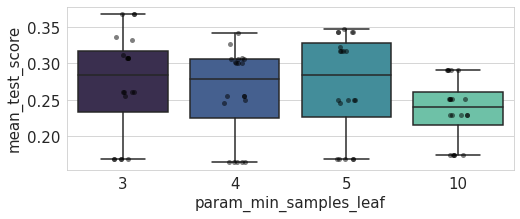

In [18]:
plt.figure(figsize=(8,3))
sns.boxplot(x = 'param_min_samples_leaf', y = 'mean_test_score', data = df_cv_result_tree,palette="mako")
sns.stripplot(y='mean_test_score', x='param_min_samples_leaf', 
                   data=df_cv_result_tree, jitter=True,marker='o', alpha=0.5,color='black')

<AxesSubplot:xlabel='param_min_samples_split', ylabel='mean_test_score'>

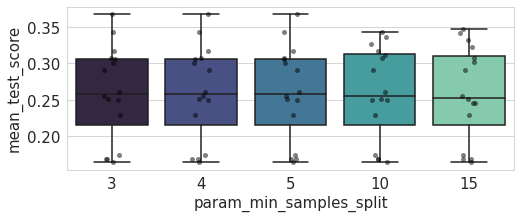

In [19]:
plt.figure(figsize=(8,3))
sns.boxplot(x = 'param_min_samples_split', y = 'mean_test_score', data = df_cv_result_tree,palette="mako")
sns.stripplot(y='mean_test_score', x='param_min_samples_split', 
                   data=df_cv_result_tree, jitter=True,marker='o', alpha=0.5,color='black')

### Sensetivity Analysis to max_depth change

In [20]:
# Create the parameter grid
param_grid = {
    'max_depth': [1,2,3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'min_samples_leaf': [5],
    'min_samples_split': [10]
}

# Instantiate the grid search model
tree_cv = GridSearchCV(estimator = tree_1, param_grid = param_grid, scoring = 'recall', cv = 10, n_jobs = -1, verbose = 0)
tree_cv.fit(X_train, Y_train)

df_sensetivity = pd.DataFrame(tree_cv.cv_results_)
df_sensetivity[['param_max_depth','split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'mean_fit_time',
       'rank_test_score']].rename(columns = {'param_max_depth':'max_depth' ,
                                            'param_min_samples_leaf':'min_sample_leaf',
                                            'param_min_samples_split':'min_sample_split',
                                            'mean_fit_time': 'mean_time',
                                            'mean_test_score': 'mean_score',
                                            'rank_test_score': 'rank_score',
                                            'split0_test_score': 'CV0', 'split1_test_score': 'CV1',
                                            'split2_test_score': 'CV2', 'split3_test_score': 'CV3',
                                            'split4_test_score': 'CV4', 'split5_test_score': 'CV5',
                                            'split6_test_score': 'CV6', 'split7_test_score': 'CV7',
                                            'split8_test_score': 'CV8', 'split9_test_score': 'CV9',
                                            }).sort_values(by='rank_score').head()

,max_depth,CV0,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,mean_score,mean_time,rank_score
9,10,0.4,0.3,0.2,0.2,0.45,0.35,0.368421,0.578947,0.157895,0.421053,0.342632,0.009704,1
17,18,0.4,0.3,0.2,0.2,0.45,0.25,0.368421,0.578947,0.157895,0.421053,0.332632,0.011261,2
16,17,0.4,0.3,0.2,0.2,0.45,0.25,0.368421,0.578947,0.157895,0.421053,0.332632,0.011312,2
15,16,0.4,0.3,0.2,0.2,0.45,0.25,0.368421,0.578947,0.157895,0.421053,0.332632,0.010077,2
14,15,0.4,0.3,0.2,0.2,0.45,0.25,0.368421,0.578947,0.157895,0.421053,0.332632,0.009671,2


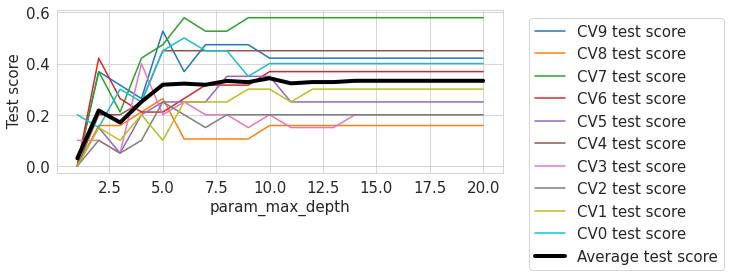

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


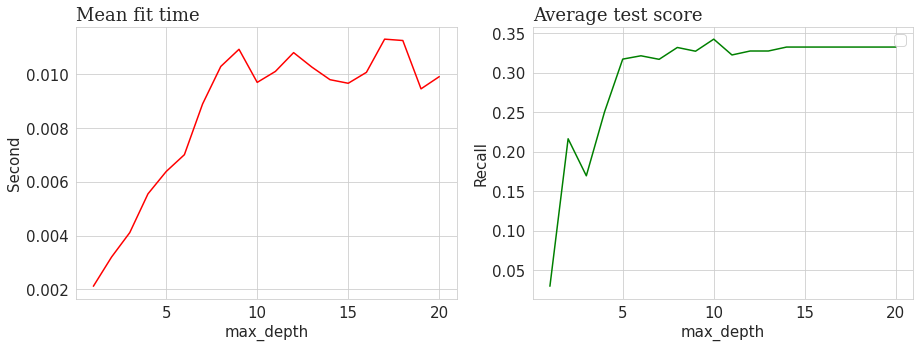

In [21]:
plt.figure(figsize=(8,3))
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split9_test_score'], label="CV9 test score ")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split8_test_score'], label="CV8 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split7_test_score'], label="CV7 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split6_test_score'], label="CV6 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split5_test_score'], label="CV5 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split4_test_score'], label="CV4 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split3_test_score'], label="CV3 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split2_test_score'], label="CV2 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split1_test_score'], label="CV1 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['split0_test_score'], label="CV0 test score")
plt.plot(df_sensetivity['param_max_depth'],df_sensetivity['mean_test_score'], label="Average test score",color='black', linewidth=4)
#plt.axvline(496, color="gray", label="Optimal tree number")
plt.xlabel("param_max_depth")
plt.ylabel(" Test score")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show();

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(df_sensetivity['param_max_depth'],df_sensetivity['mean_fit_time'],color='red')
ax1.set_title('Mean fit time', fontfamily='serif', loc='left', fontsize='large')
ax1.set(xlabel='max_depth', ylabel='Second')

ax2.plot(df_sensetivity['param_max_depth'],df_sensetivity['mean_test_score'],color='green')
ax2.set_title('Average test score', fontfamily='serif', loc='left', fontsize='large')
ax2.set(xlabel='max_depth', ylabel='Recall')

plt.legend()
plt.show();



# Random Forest

In [22]:
#Show the Confusion matrix and accaracy score for the model on the test data
forest = RandomForestClassifier(random_state=2)
forest.fit(X_train, Y_train)

evaluate(forest, Y_test, X_test,X_train,Y_train)


Accuracy Score on train dataset :  1.0
Accuracy_score on test dataset :  0.88 

Model Performance
Precision: 1.0
Recall: 0.12
Accuracy:0.88
F1-score: : 0.22 



# RF- Grid Search

In [23]:
param_grid = {
    'max_depth': [2,4,6,8,10],
    'max_features': [2,4,6,8,10],
    'n_estimators': [10,20,30,40,50]
}
forest_cv = GridSearchCV(estimator = forest, param_grid = param_grid,  scoring = 'f1', cv = 10, n_jobs = -1, verbose = 0)
forest_cv.fit(X_train, Y_train)
evaluate(forest_cv, Y_test, X_test,X_train,Y_train)

Accuracy Score on train dataset :  0.93
Accuracy_score on test dataset :  0.86 

Model Performance
Precision: 0.57
Recall: 0.1
Accuracy:0.86
F1-score: : 0.17 



# RF- Random Search 

In [24]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

n_iter_search = 20
random_search = RandomizedSearchCV(forest, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, Y_train)
evaluate(random_search, Y_test, X_test,X_train,Y_train)

best_params = random_search.best_params_
print(f"Best paramters Random Search: {best_params})")

Accuracy Score on train dataset :  0.96
Accuracy_score on test dataset :  0.87 

Model Performance
Precision: 0.62
Recall: 0.12
Accuracy:0.87
F1-score: : 0.2 

Best paramters Random Search: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 8})


# RF- Bayesian Search 

In [25]:
param_dist =  {
        'n_estimators': (5,100),
        'max_features': ['auto','sqrt'],
        'max_depth': (2,20),
        'min_samples_split': (2,10),
        'min_samples_leaf': (1,7),
        'bootstrap': ["True","False"]
    }

search = BayesSearchCV(estimator=forest, search_spaces=param_dist, n_jobs=-1, n_iter=32,cv=3, scoring='roc_auc')
search.fit(X_train, Y_train)
print(search.best_score_)
print(search.best_params_)
evaluate(search, Y_test, X_test,X_train,Y_train)


0.7899335825491057
OrderedDict([('bootstrap', 'True'), ('max_depth', 6), ('max_features', 'auto'), ('min_samples_leaf', 7), ('min_samples_split', 4), ('n_estimators', 66)])
Accuracy Score on train dataset :  0.87
Accuracy_score on test dataset :  0.87 

Model Performance
Precision: 0.8
Recall: 0.1
Accuracy:0.87
F1-score: : 0.17 



# GBM 

In [26]:
gbm = GradientBoostingClassifier(n_estimators=100,random_state=2)
gbm.fit(X_train, Y_train)
evaluate(gbm, Y_test, X_test,X_train,Y_train)
######################

Accuracy Score on train dataset :  0.96
Accuracy_score on test dataset :  0.88 

Model Performance
Precision: 0.73
Recall: 0.27
Accuracy:0.88
F1-score: : 0.39 



In [27]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
     'min_samples_leaf': [5,10,15],
    'max_features': [4,6,8,10]
    }
gbm_cv = GridSearchCV(estimator = gbm, param_grid = param_grid, scoring = 'f1',cv = 10, n_jobs = -1, verbose = 2)
gbm_cv.fit(X_train, Y_train)

evaluate(gbm_cv, Y_test, X_test,X_train,Y_train)

best_params = gbm_cv.best_params_
print(f"Best paramters: {best_params})")

Fitting 10 folds for each of 84 candidates, totalling 840 fits
Accuracy Score on train dataset :  0.94
Accuracy_score on test dataset :  0.9 

Model Performance
Precision: 0.87
Recall: 0.32
Accuracy:0.9
F1-score: : 0.46 

Best paramters: {'learning_rate': 0.15, 'max_features': 6, 'min_samples_leaf': 15})


# XGBoost (eXtreme Gradient Boosting)

In [28]:
xgbc = XGBClassifier(random_state=2)
xgbc.fit(X_train, Y_train)
evaluate(xgbc, Y_test, X_test,X_train,Y_train)

Accuracy Score on train dataset :  1.0
Accuracy_score on test dataset :  0.89 

Model Performance
Precision: 0.76
Recall: 0.32
Accuracy:0.89
F1-score: : 0.45 



## Cross Validation XGB

In [29]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
     'reg_alpha': [0,.2,.4,.6,.8,1],
     'reg_lambda': [0,.2,.4,.6,.8,1]
    }

xgbm_cv = GridSearchCV(estimator = xgbc, param_grid = param_grid, scoring = 'f1',cv = 10, n_jobs = -1, verbose = 0)
xgbm_cv.fit(X_train, Y_train)
evaluate(xgbm_cv, Y_test, X_test,X_train,Y_train)

best_params = xgbm_cv.best_params_
print(f"Best paramters: {best_params})")

Accuracy Score on train dataset :  1.0
Accuracy_score on test dataset :  0.88 

Model Performance
Precision: 0.77
Recall: 0.24
Accuracy:0.88
F1-score: : 0.37 

Best paramters: {'learning_rate': 0.2, 'reg_alpha': 0, 'reg_lambda': 0.6})


# Ada Boosting

In [30]:
ada = AdaBoostClassifier()

ada.fit(X_train, Y_train)
evaluate(ada, Y_test, X_test,X_train,Y_train)

Accuracy Score on train dataset :  0.9
Accuracy_score on test dataset :  0.87 

Model Performance
Precision: 0.56
Recall: 0.22
Accuracy:0.87
F1-score: : 0.32 



In [31]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

ada_cv = GridSearchCV(ada, parameters,verbose=0,scoring='f1',n_jobs=-1)
ada_cv.fit(X_train,Y_train)
evaluate(ada_cv, Y_test, X_test,X_train,Y_train)

Accuracy Score on train dataset :  0.95
Accuracy_score on test dataset :  0.89 

Model Performance
Precision: 0.83
Recall: 0.24
Accuracy:0.89
F1-score: : 0.38 



# Ensemble Stacking 

In [ ]:
from sklearn.ensemble import StackingClassifier

level0 = list()
level0.append(('Ada', ada_cv))
level0.append(('XGBOOST', xgbm_cv))
level0.append(('GBM', gbm_cv))
level0.append(('RF', forest_cv))
level0.append(('Tree', tree_cv))
level1 = LogisticRegression()
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train,Y_train)

In [33]:
evaluate(ada_cv, Y_test, X_test,X_train,Y_train)

Accuracy Score on train dataset :  0.95
Accuracy_score on test dataset :  0.89 

Model Performance
Precision: 0.83
Recall: 0.24
Accuracy:0.89
F1-score: : 0.38 



# Models Comparison

In [34]:
models = []
models.append(('RF- Grid', forest_cv))
models.append(('RF- Rndom', random_search))
models.append(('RF Bayesian', search))
models.append(('Ada Boosting', ada_cv))
models.append(('Decision Tree Classifier', tree_cv))
models.append(('XGBoost Classifier', xgbm_cv))
models.append(('GBM Classifier', gbm_cv))
models.append(('Ada Boosting', ada_cv))
models.append(('Stacking', model))

In [ ]:
#models.append(('Random Forest', RandomForestClassifier(**forest_cv.best_params_)))
#models.append(('Decision Tree Classifier', DecisionTreeClassifier(** tree_cv.best_params_)))
#models.append(('XGBoost Classifier', XGBClassifier(** xgbm_cv.best_params_)))
#models.append(('GBM Classifier', GradientBoostingClassifier(** gbm_cv.best_params_)))
#models.append(('Ada Boosting', AdaBoostClassifier(** ada_cv.best_params_)))
#models.append(('Stacking', StackingClassifier(** model.best_params_)))
acur_results =[]
auc_results = []
f1_results = []
recall_results = []
precision_results = []
    
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'Accuracy mean', 'AUC mean', 
       'F1-Score mean', 'Recall mean' , 'Precision mean']
df_results = pd.DataFrame(columns=col)
i = 0

# evaluate each model using cross-validation
for name, model in models:
    print(name,model)
    kfold = model_selection.KFold(n_splits=5)  # 10-fold cross-validation

    cv_acur_results = model_selection.cross_val_score(  # accuracy scoring
        model, X_train, Y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, Y_train, cv=kfold, scoring='roc_auc')
    
    cv_f1_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, Y_train, cv=kfold, scoring='f1')

    cv_recall_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, Y_train, cv=kfold, scoring='recall')

    cv_precision_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, Y_train, cv=kfold, scoring='precision')
    
    acur_results.append(cv_acur_results)
    auc_results.append(cv_auc_results)
    f1_results.append(cv_f1_results)
    recall_results.append(cv_recall_results)
    precision_results.append(cv_precision_results)

    
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_acur_results.mean()*100, 2),
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_f1_results.mean()*100, 2),
                         round(cv_recall_results.mean()*100, 2),
                         round(cv_precision_results.mean()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['F1-Score mean'], ascending=False)

In [ ]:
df_results

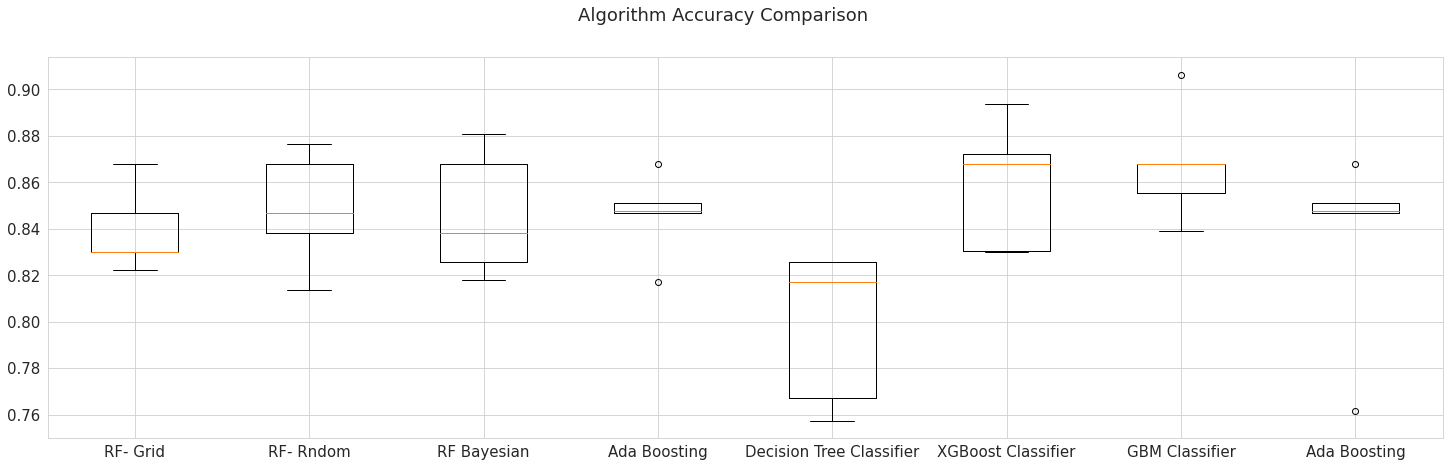

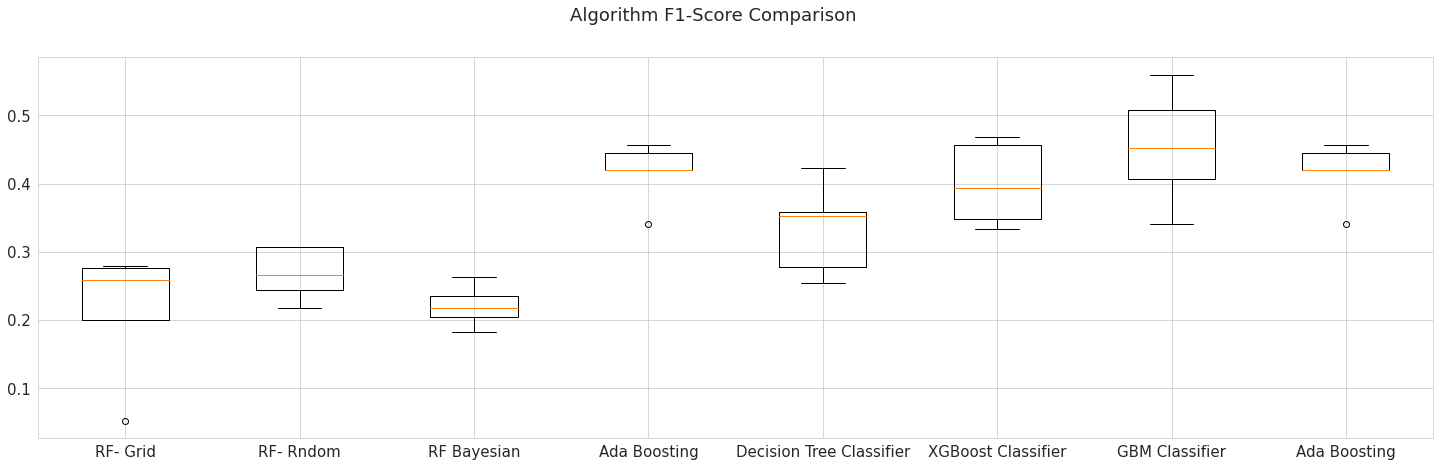

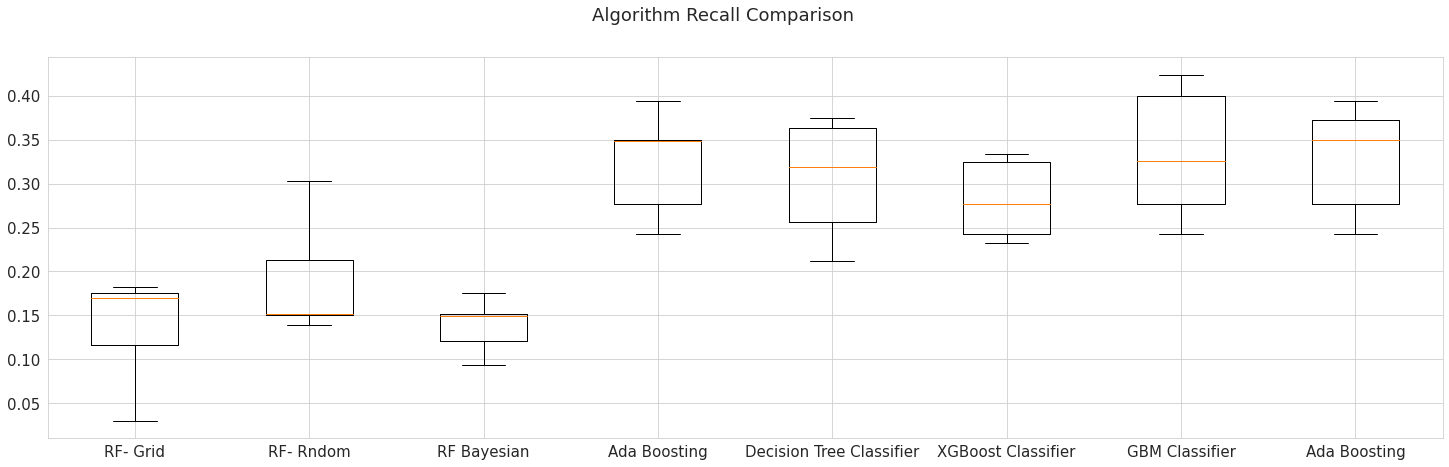

In [40]:
fig = plt.figure(figsize=(25, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acur_results)
ax.set_xticklabels(names)
plt.show()

fig = plt.figure(figsize=(25, 7))
fig.suptitle('Algorithm F1-Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(f1_results)
ax.set_xticklabels(names)
plt.show()

fig = plt.figure(figsize=(25, 7))
fig.suptitle('Algorithm Recall Comparison')
ax = fig.add_subplot(111)
plt.boxplot(recall_results)
ax.set_xticklabels(names)
plt.show()

# Feature Importance

In [55]:
k=data_transformed.drop(['Attrition_Yes'], axis=1).columns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


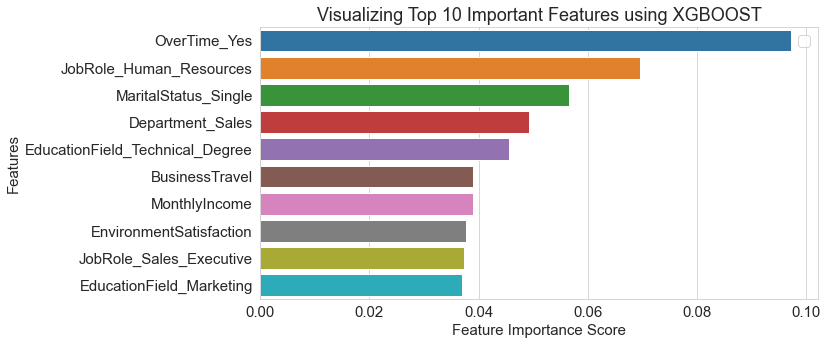

In [58]:
feature_imp_xgb = pd.Series(xgbm_clf.feature_importances_,index=k).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feature_imp_xgb[0:10], y=feature_imp_xgb.index[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Top 10 Important Features using XGBOOST")
plt.legend()
plt.show()

# Models Comparison

In [63]:
model = xgbm_cv
print(model.classes_)
predict_test = model.predict_proba(X_test)[:,1]

[0 1]


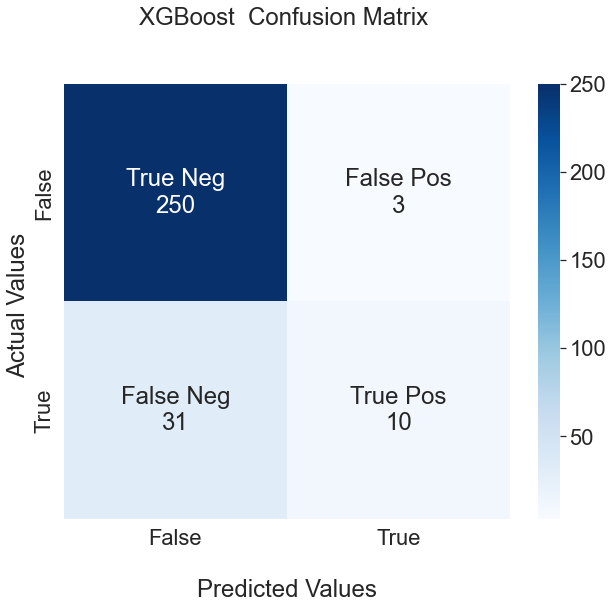

In [64]:
predictions_nominal = [ 0 if x < .5  else 1 for x in predict_test]

cf_matrix=confusion_matrix(Y_test,  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('XGBoost  Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [65]:
precision = precision_score(Y_test,  predictions_nominal)
recall = recall_score(Y_test,  predictions_nominal)
accuracy= accuracy_score(Y_test,  predictions_nominal)
F1_score= f1_score(Y_test,  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

Precision: 0.77
Recall: 0.24
Accuracy: 0.88
F1-score: : 0.37


# Optimal Threshold

Area under the ROC curve : 0.862142


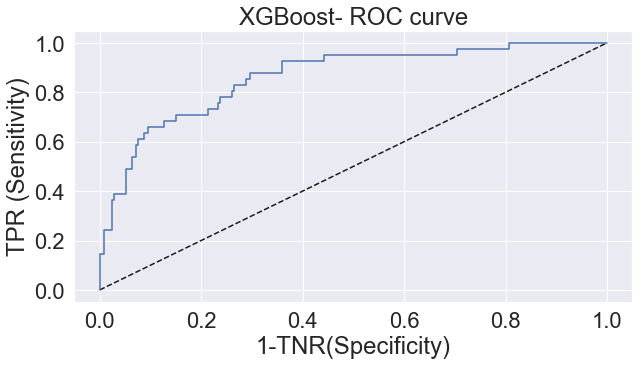

In [66]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds =roc_curve(Y_test, predict_test)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='XGBoost')
plt.xlabel('1-TNR(Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('XGBoost- ROC curve')
plt.show()

         fpr       tpr     1-fpr  difference  thresholds
0   0.000000  0.000000  1.000000   -1.000000    1.983722
1   0.000000  0.024390  1.000000   -0.975610    0.983723
2   0.000000  0.048780  1.000000   -0.951220    0.977928
3   0.003953  0.048780  0.996047   -0.947267    0.959795
4   0.003953  0.195122  0.996047   -0.800925    0.741058
5   0.007905  0.195122  0.992095   -0.796973    0.732220
6   0.007905  0.243902  0.992095   -0.748192    0.692996
7   0.011858  0.243902  0.988142   -0.744240    0.689061
8   0.011858  0.365854  0.988142   -0.622289    0.588963
9   0.031621  0.365854  0.968379   -0.602526    0.502995
10  0.031621  0.414634  0.968379   -0.553745    0.475977
11  0.047431  0.414634  0.952569   -0.537935    0.419985
12  0.047431  0.439024  0.952569   -0.513545    0.384959
13  0.055336  0.439024  0.944664   -0.505640    0.360089
14  0.055336  0.463415  0.944664   -0.481249    0.318437
15  0.063241  0.463415  0.936759   -0.473344    0.302813
16  0.063241  0.487805  0.93675

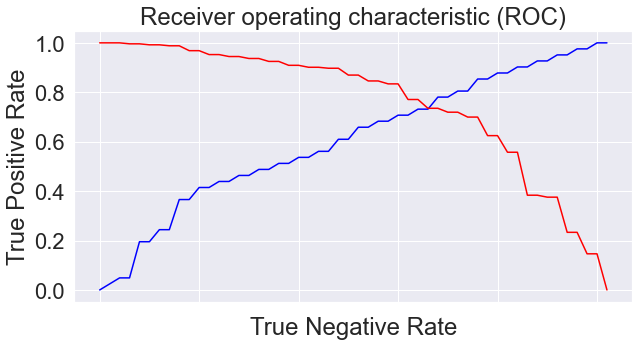

In [70]:
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'difference' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
print(roc)
##
print(roc.iloc[(roc.difference-0).abs().argsort()[:1]])

# Plot tpr vs 1-fpr
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(roc['tpr'],color='blue')
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
ax.set_xticklabels([])
plt.savefig('ROC_optimal.png')


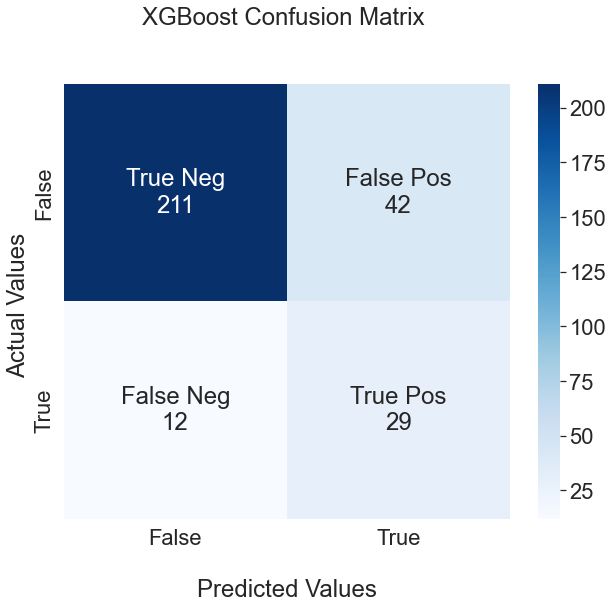

In [67]:
predictions_nominal = [ 0 if x <  0.05037 else 1 for x in predict_test]

cf_matrix=confusion_matrix(Y_test,  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('XGBoost Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


In [68]:
precision = precision_score(Y_test,  predictions_nominal)
recall = recall_score(Y_test,  predictions_nominal)
accuracy= accuracy_score(Y_test,  predictions_nominal)
F1_score= f1_score(Y_test,  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

Precision: 0.41
Recall: 0.71
Accuracy: 0.82
F1-score: : 0.52
